# Text Classification (Multi-classes) with LSTM (keras)

: This is the testing code for multi-classes text classification using a deep learning algorithms  
: The applyed algorithms is (Recurrent Neural Network - LSTM (Long Short Term Memory))
: Input dataset is 'AG 20 news group' from sklearn / original resources: http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html
:Python version 3.5

In [1]:
# Basic Python packages
import pandas as pd
import numpy as np
import statistics as stat
import math
import re
import string
from cytoolz import concat

In [2]:
# Import the input dataset - AG's newsgroup
# The AG News corpus consists of news articles from the AG's corpus of news articles on the web 
# pertaining to the 4 largest classes. 
# The dataset contains 30,000 training examples for each class 1,900 examples for each class for testing. 
# dataset.data --> documents / dataset.target_names --> target

from sklearn.datasets import fetch_20newsgroups
#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
#documents = dataset.data
#target = dataset.target
#len(dataset.filenames)

remove = ['headers', 'footers', 'quotes']

data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=remove)

data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=remove)

In [3]:
len(data_train.data)

11314

# Data Descriptive Analysis
: get some idea of your input dataset

In [27]:
# Make the dataset as a Dataframe for descriptive analysis
df_train = pd.DataFrame({'label':data_train.target, 'text':data_train.data})
df_test  = pd.DataFrame({'label':data_test.target, 'text':data_test.data})
print(df_train.info(),df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
label    11314 non-null int32
text     11314 non-null object
dtypes: int32(1), object(1)
memory usage: 132.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7532 entries, 0 to 7531
Data columns (total 2 columns):
label    7532 non-null int32
text     7532 non-null object
dtypes: int32(1), object(1)
memory usage: 88.3+ KB
None None


In [28]:
df_train.head()

,label,text
0,7,I was wondering if anyone out there could enli...
1,4,A fair number of brave souls who upgraded thei...
2,4,"well folks, my mac plus finally gave up the gh..."
3,1,\nDo you have Weitek's address/phone number? ...
4,14,"From article <C5owCB.n3p@world.std.com>, by to..."


In [29]:
# Target Distribution

categories = data_test.target_names

def target_distribution(data, category):
    target_dist = data['label'].value_counts() 
    target_dist = target_dist.reset_index(drop=False)
    target_dist = target_dist.rename(columns = {'index':'label', 'label':'count'})    
    target_dist = target_dist.sort_values(by=['label'])
    #print(target_dist)
    
    categories = category
    names = [[category.index(cat), cat] for cat in categories]
    names.sort()
    #print(names)
    df_names = pd.DataFrame(names[0:], columns={'name','label'})
    df_names = df_names.rename(columns={'name': 'label', 'label':'name'})
    #print(df_names)

    df = pd.merge(target_dist, df_names, on='label')
        
    return df


In [30]:
df_train_dist = target_distribution(df_train, categories)
df_test_dist = target_distribution(df_test, categories)

In [87]:
df_train_dist

,label,count,name
0,0,480,alt.atheism
1,1,584,comp.graphics
2,2,591,comp.os.ms-windows.misc
3,3,590,comp.sys.ibm.pc.hardware
4,4,578,comp.sys.mac.hardware
5,5,593,comp.windows.x
6,6,585,misc.forsale
7,7,594,rec.autos
8,8,598,rec.motorcycles
9,9,597,rec.sport.baseball


In [88]:
df_train_dist.groupby('name')['count'].sum()

name
alt.atheism                 480
comp.graphics               584
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
comp.sys.mac.hardware       578
comp.windows.x              593
misc.forsale                585
rec.autos                   594
rec.motorcycles             598
rec.sport.baseball          597
rec.sport.hockey            600
sci.crypt                   595
sci.electronics             591
sci.med                     594
sci.space                   593
soc.religion.christian      599
talk.politics.guns          546
talk.politics.mideast       564
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64

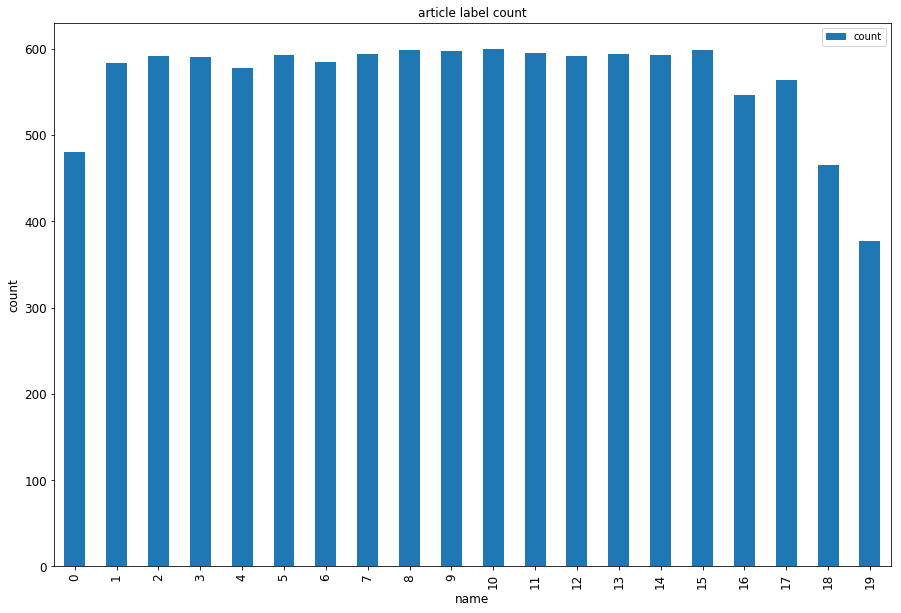

In [86]:
import matplotlib.pyplot as plt

ax = df_train_dist[['name','count']].plot(kind='bar', title ="article label count", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("name", fontsize=12)
ax.set_ylabel("count", fontsize=12)
plt.show()

# Data Pre-processing on the text column

In [42]:
# Null value checking - No null - ok
#df_test = df_test.fillna('') # change NaN to null ('')
def null_check(data):
    df_null = data[data['text'].isnull() == True]
    
    print(len(df_null))
    
null_check(df_train)
null_check(df_test)

0
0


In [43]:
# Remove punctuation and all exotic, non-meaningful characters
# Change into the lower case
# Remove white spaces
# Tokenization

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocessing(data):
    data['text'] = data['text'].astype(str).str.replace('[{}]'.format(string.punctuation), ' ') # remove punctuation
    data['text'] = data['text'].astype(str).str.lower() # character lowering
    data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) # remove english stopwords
    data['text'] = data['text'].astype(str).str.strip() # remove whitespace
    #data['text'] = data['text'].str.split() # tokenization
    
    return data


In [44]:
df_train = preprocessing(df_train)
df_test = preprocessing(df_test)

In [45]:
# Null Checking Again - can't find the empty cell...
null_check(df_train)
null_check(df_test)

0
0


In [46]:
# As I observe the empty cell in text column in a couple of rows - 11310, replace the empty cell into NaN and delete them

def empty_handling(data):
    data = data.replace(r'^\s*$', np.nan, regex = True)
    nan_test = data[data['text'].isnull() == True]
    
    
    if len(nan_test) > 0:
        df = data[data['text'].isnull() == False]
        df = df.reset_index(drop = True)
        print('NaN number:', len(nan_test))
    else:
        df = data
        print('no NaN')
    
    return df


In [47]:
df_train = empty_handling(df_train)
df_test = empty_handling(df_test)

NaN number: 314
NaN number: 228


In [48]:
# Descriptive Analysis after data cleansing

print(df_train.info(),df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
label    11000 non-null int64
text     11000 non-null object
dtypes: int64(1), object(1)
memory usage: 172.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7304 entries, 0 to 7303
Data columns (total 2 columns):
label    7304 non-null int64
text     7304 non-null object
dtypes: int64(1), object(1)
memory usage: 114.2+ KB
None None


In [51]:
df_train.head()

,label,text
0,7,wondering anyone could enlighten car saw day 2...
1,4,fair number brave souls upgraded si clock osci...
2,4,well folks mac plus finally gave ghost weekend...
3,1,weitek address phone number like get informati...
4,14,article c5owcb n3p world std com tombaker worl...


In [49]:
# Check the corpus vocabrary size check 
# Let's get some idea of the corpus and vocabrary

from nltk.tokenize import word_tokenize

def corpus_vocab_check(data):
    bow = data['text'].apply(word_tokenize)
    f = pd.DataFrame({'all': pd.value_counts(list(concat(bow)))})
    #f.sort_values('all', ascending=False)
    
    corpus_size, vocab_size = len(data['text']), len(f)
    
    return print('Corpus_size:', corpus_size, 'Vocab_size:', vocab_size)


In [50]:
corpus_vocab_check(df_train)
corpus_vocab_check(df_test)

Corpus_size: 11000 Vocab_size: 100728
Corpus_size: 7304 Vocab_size: 70012


In [60]:
# Concat the train and test set for Deep Learning
df = pd.concat([df_train, df_test], axis = 0)
df.head()
#len(df)

,label,text
0,7,wondering anyone could enlighten car saw day 2...
1,4,fair number brave souls upgraded si clock osci...
2,4,well folks mac plus finally gave ghost weekend...
3,1,weitek address phone number like get informati...
4,14,article c5owcb n3p world std com tombaker worl...


# LSTM (Long Short Term Memory) Model Building

In [71]:
# import keras libraries for various text mining techniques

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO #ipython sometimes messes up the logging setup; then restore


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, SpatialDropout1D
from keras.utils.np_utils import to_categorical


In [54]:
# model performance matrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
# Parameter setting

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each document.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 130010 unique tokens.


In [65]:
# Pad sequencing to make all inputs in the same length of input
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (18304, 250)


In [76]:
# Conver the categorical labels into the numbers

Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (18304, 20)


In [77]:
# Train & Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16473, 250) (16473, 20)
(1831, 250) (1831, 20)


In [78]:
# LSTM Model Building
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(20, activation='softmax'))
#opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['acc',f1_m,precision_m, recall_m])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

es = EarlyStopping(monitor='val_loss', mode = min, patience=3, min_delta=0.0001)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[es])

c:\users\great\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\keras\callbacks.py:502: RuntimeWarning: EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Train on 14825 samples, validate on 1648 samples
Epoch 1/5
14825/14825 [==============================] - 331s 22ms/step - loss: 2.6487 - acc: 0.1456 - val_loss: 2.1399 - val_acc: 0.2676
Epoch 2/5
14825/14825 [==============================] - 130s 9ms/step - loss: 1.8897 - acc: 0.3576 - val_loss: 1.7687 - val_acc: 0.4011
Epoch 3/5
14825/14825 [==============================] - 129s 9ms/step - loss: 1.3743 - acc: 0.5396 - val_loss: 1.4606 - val_acc: 0.5461
Epoch 4/5
14825/14825 [==============================] - 130s 9ms/step - loss: 0.9341 - acc: 0.7056 - val_loss: 1.2908 - val_acc: 0.6032
Epoch 5/5
14825/14825 [==============================] - 129s 9ms/step - loss: 0.6537 - acc: 0.8010 - val_loss: 1.2454 - val_acc: 0.6359


In [79]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2020      
Total params: 5,082,420
Trainable params: 5,082,420
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1831/1831 [==============================] - 12s 7ms/step
Test set
  Loss: 1.203
  Accuracy: 0.640


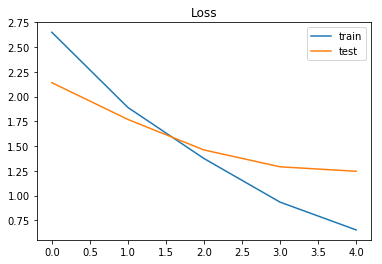

In [81]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

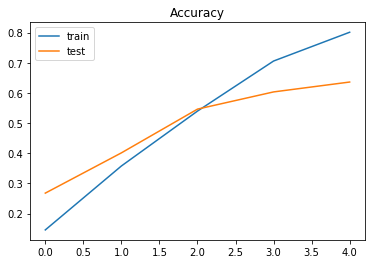

In [82]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();